# Representation of a Fiber Diffraction / Grazing Incidence pattern

### As with fibers, during a grazing-incidence scattering experiments (GIWAXS, GISAXS) on a thin film, a fiber symmetry is usually considered

Inside a fiber, there is a vertical axis with specific crystalline planes while the radial axis are equivalent

The same way, for a thin film, it is common to split the q vector in a vertical component (along the thickness axis) and an in-plane component

In [1]:
from pyFAI.calibrant import get_calibrant
from pyFAI.detectors import RayonixLx255, Pilatus1M
from pyFAI.integrator.azimuthal import AzimuthalIntegrator
from pyFAI.gui import jupyter
from pyFAI.test.utilstest import UtilsTest
from pyFAI.units import get_unit_fiber
import fabio
import numpy as np
from PIL import Image
from pyFAI import load
import matplotlib.pyplot as plt
import time
t0 = time.perf_counter()

### In pyFAI: 

x is the horizontal axis of the lab

y is the vertical axis of the lab

z is the beam propagation axis

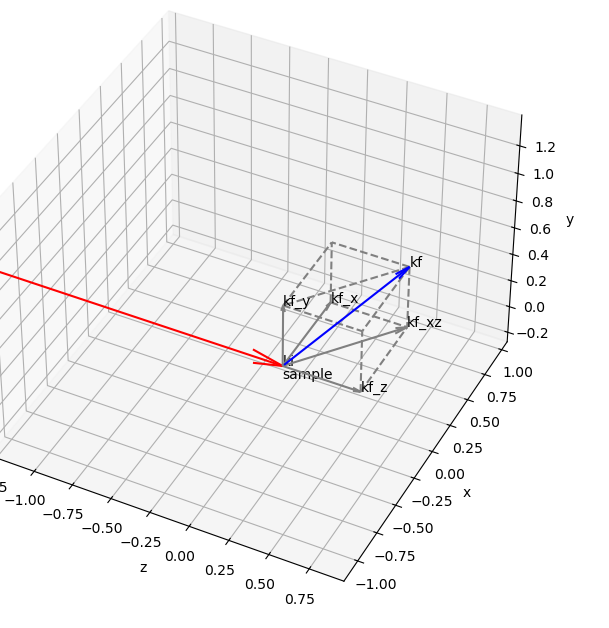

In [2]:
Image.open(UtilsTest.getimage("giwaxs.png"))

#### We simulate data with the calibrant LaB6

In [3]:
cal = get_calibrant("LaB6")
det = Pilatus1M()
ai = AzimuthalIntegrator(detector=det, poni1=0.05, poni2=0.01, dist=0.1, wavelength=1e-10)
fake_data = cal.fake_calibration_image(ai=ai)

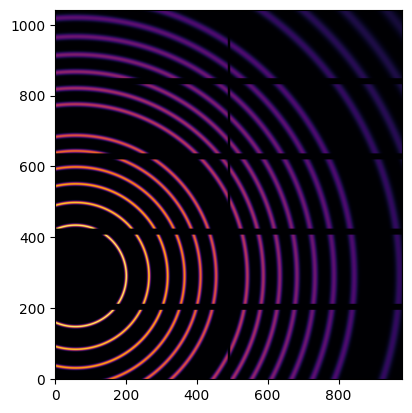

In [4]:
jupyter.display(fake_data)
pass

#### To represent the image as a function of in-plane and out-of-plane components of the q vector

In [5]:
unit_qx = "qxgi_nm^-1"
unit_qy = "qygi_nm^-1"
unit_qz = "qzgi_nm^-1"

In [6]:
qx = ai.array_from_unit(unit=unit_qx)
qy = ai.array_from_unit(unit=unit_qy)
qz = ai.array_from_unit(unit=unit_qz)

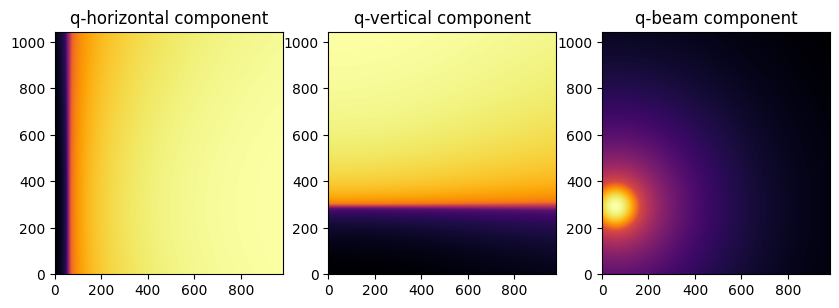

In [7]:
fig, axes = jupyter.subplots(ncols=3, figsize=(10,5))
jupyter.display(img=qx, ax=axes[0], label="q-horizontal component")
jupyter.display(img=qy, ax=axes[1], label="q-vertical component")
jupyter.display(img=qz, ax=axes[2], label="q-beam component")
pass

In [8]:
unit_qip = "qip_nm^-1"
unit_qoop = "qoop_nm^-1"
qip = ai.array_from_unit(unit=unit_qip)
qoop = ai.array_from_unit(unit=unit_qoop)

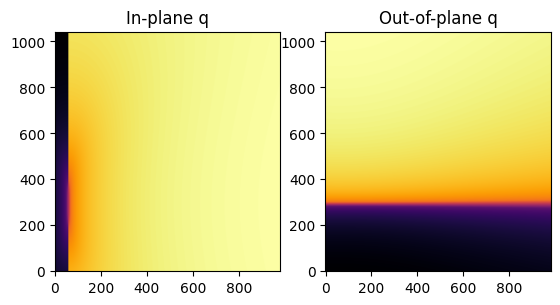

In [9]:
fig, axes = jupyter.subplots(ncols=2)
jupyter.display(img=qip, ax=axes[0], label="In-plane q")
jupyter.display(img=qoop, ax=axes[1], label="Out-of-plane q")
pass

### Then, GIWAXS and GISAXS patterns are represented as a function of qip and qoop

So, the horizontal component multiplied by the beam component yields the characteristic "missing wedge" of the pattern

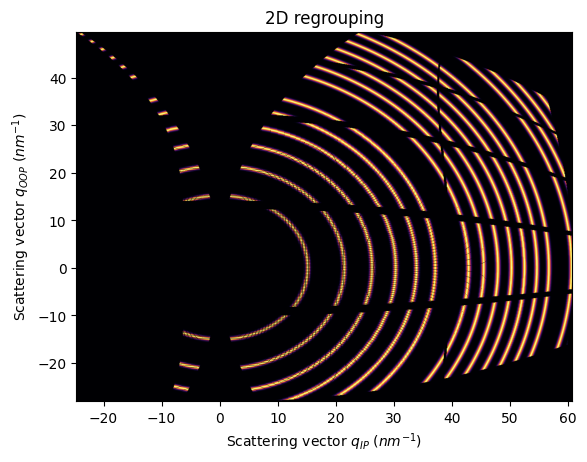

In [10]:
res2d = ai.integrate2d(fake_data, 1000,1000, unit=(unit_qip, unit_qoop), method=("no", "csr", "cython"))
jupyter.plot2d(res2d)
pass

**Note:** it is important to **disable pixel splitting** in the regrouping method, otherwise, the gap is filled

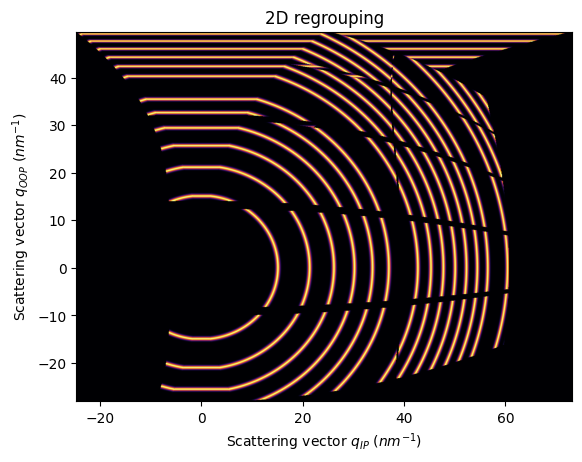

In [11]:
res2d = ai.integrate2d(fake_data, 1000,1000, unit=(unit_qip, unit_qoop), method=("bbox", "csr", "cython"))
jupyter.plot2d(res2d)
pass

### For the fiber/grazing-incidence units, pyFAI handles a special class of units called FiberUnits
FiberUnits can be retrieved with pyFAI.units.get_unit_fiber and they accept three input attributes: incident_angle, tilt_angle and sample_orientation

In [12]:
unit_qip = get_unit_fiber(name="qip_nm^-1", incident_angle=0.2, tilt_angle=0.4, sample_orientation=1)
unit_qoop = get_unit_fiber(name="qoop_nm^-1", incident_angle=0.2, tilt_angle=0.4, sample_orientation=1)
ai.reset()

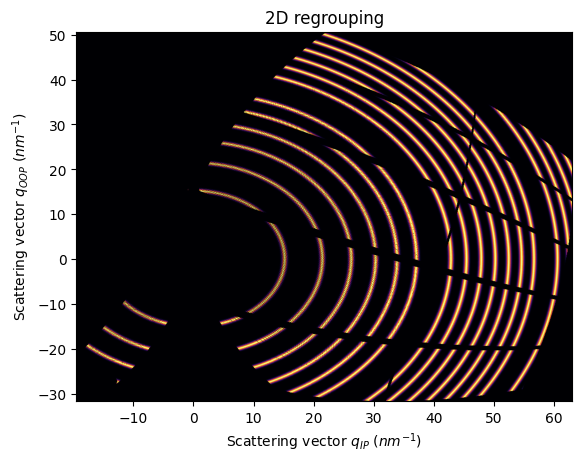

In [13]:
res2d = ai.integrate2d(fake_data, 1000,1000, unit=(unit_qip, unit_qoop), method=("no", "csr", "cython"))
jupyter.plot2d(res2d)
pass

#### Now the patterns looks tilted due to tilt_angle and the available region in the reciprocal space has been shifted

### 

#### The attribute sample_orientation takes into account the n*90 degrees difference between the fiber axis and the vertical axis of the detector

The differences are better spotted with an elongated detector

In [14]:
det = RayonixLx255()
ai = AzimuthalIntegrator(detector=det, poni1=0.05, poni2=0.01, dist=0.1, wavelength=1e-10)
fake_data = cal.fake_calibration_image(ai=ai)
ai.reset()

In [15]:
unit_qip.set_sample_orientation(1)
unit_qip.set_incident_angle(0.0)
unit_qip.set_tilt_angle(0.0)
unit_qoop.set_sample_orientation(1)
unit_qoop.set_incident_angle(0.0)
unit_qoop.set_tilt_angle(0.0)
ai.reset()

#### In this case, the incident angle goes with the short side of the detector

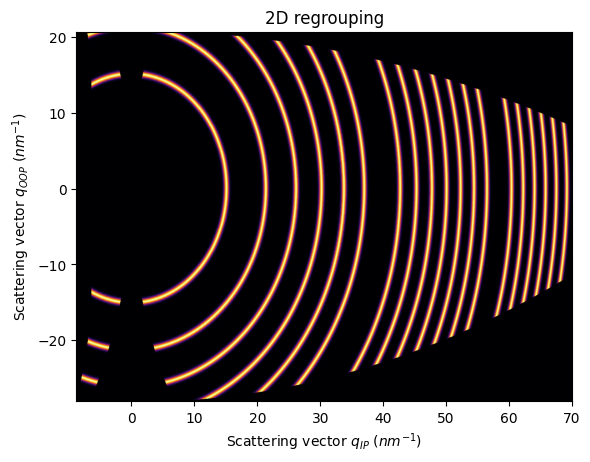

In [16]:
res2d = ai.integrate2d(fake_data, 1000,1000, unit=(unit_qip, unit_qoop), method=("no", "csr", "cython"))
jupyter.plot2d(res2d)
pass

##### Now, if we rotate the fiber axis 90 degrees, (sample_orientation=2)

In [17]:
unit_qip.set_sample_orientation(2)
unit_qoop.set_sample_orientation(2)
ai.reset()

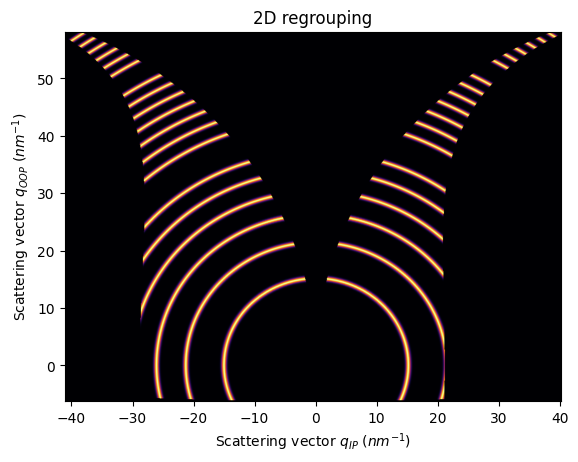

In [18]:
res2d = ai.integrate2d(fake_data, 1000,1000, unit=(unit_qip, unit_qoop), method=("no", "csr", "cython"))
jupyter.plot2d(res2d)
pass

#### Example with real GIWAXS data

In [19]:
data = fabio.open(UtilsTest.getimage("pm6.edf")).data
ai = load(UtilsTest.getimage("lab6_pm6.poni"))

##### We are still using sample_orientation=2

In [20]:
unit_qip.sample_orientation, unit_qoop.sample_orientation

(2, 2)

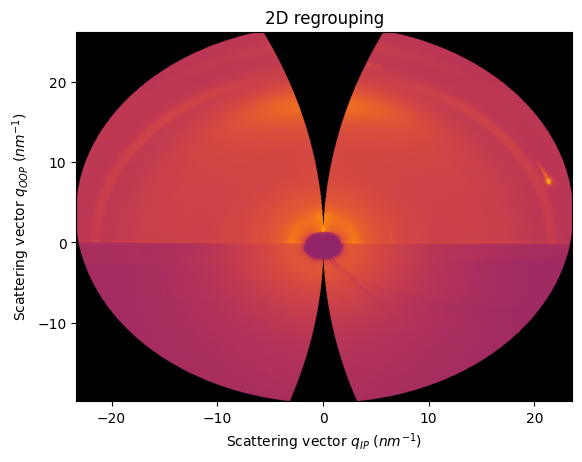

In [21]:
res2d = ai.integrate2d(data, 1000,1000, unit=(unit_qip, unit_qoop), method=("no", "csr", "cython"))
jupyter.plot2d(res2d)
pass

##### Tuning the incident and tilt angles:

In [22]:
INCIDENT_ANGLE = 0.2
TILT_ANGLE = -0.3
unit_qip.set_incident_angle(INCIDENT_ANGLE)
unit_qip.set_tilt_angle(TILT_ANGLE)
unit_qoop.set_incident_angle(INCIDENT_ANGLE)
unit_qoop.set_tilt_angle(TILT_ANGLE)
ai.reset()

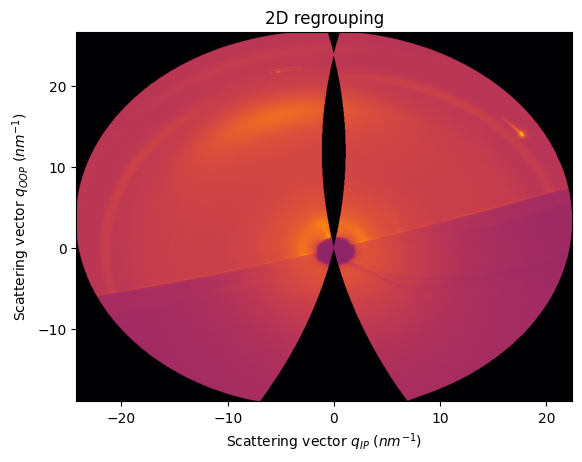

In [23]:
res2d = ai.integrate2d(data, 1000,1000, unit=(unit_qip, unit_qoop), method=("no", "csr", "cython"))
jupyter.plot2d(res2d)
pass

#### 

## Integration along a specific fiber unit
For analysis of fiber/grazing-incidence data, sometimes we need to slice the pattern along the q-oop axis, to get a set of Bragg peaks, this cannot be done using the standard cake integration

##### Let's take a GIWAXS pattern collected after illuminating a crystallized semiconducting organic thin film

In [40]:
data = fabio.open(UtilsTest.getimage("Y6.edf")).data
fi = load(UtilsTest.getimage("LaB6_3.poni"), type_='pyFAI.integrator.fiber.FiberIntegrator')
INCIDENT_ANGLE = 0.0
TILT_ANGLE = 0.0
unit_qip.set_incident_angle(INCIDENT_ANGLE)
unit_qip.set_tilt_angle(TILT_ANGLE)
unit_qoop.set_incident_angle(INCIDENT_ANGLE)
unit_qoop.set_tilt_angle(TILT_ANGLE)
fi.reset()

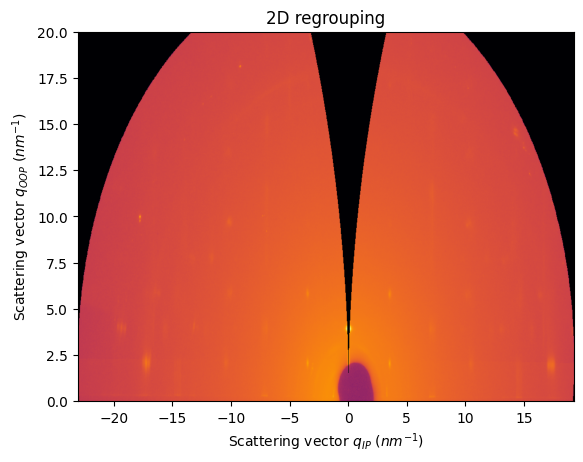

In [41]:
fig, ax = jupyter.subplots()
res2d = fi.integrate2d(data, 1000,1000, unit=(unit_qip, unit_qoop), method=("no", "csr", "cython"))
jupyter.plot2d(res2d, ax=ax)
ax.set_ylim((0,20))
pass

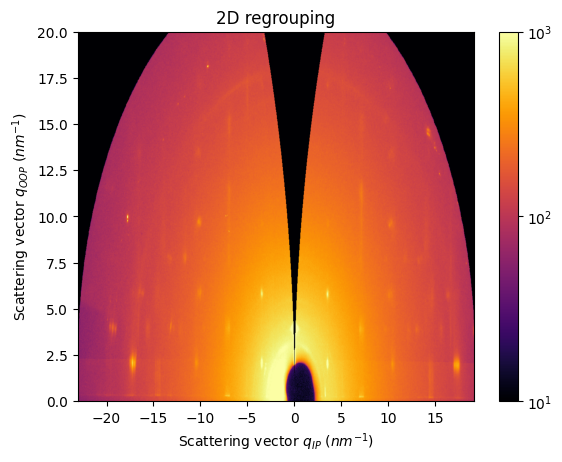

In [42]:
cax = ax.get_children()[0]
cbar = fig.colorbar(cax)
cbar.norm.vmin = 10
cbar.norm.vmax = 1e3
ax.get_figure()

##### In this case, a cake integration is not accurate to capture, for example, the Bragg peaks rods at qIP=7 and 10 nm-1
Now, pyFAI allows to do this with the method pyFAI.AzimuthalIntegrator.integrate_fiber

In [57]:
res_q7 = fi.integrate_fiber(data=data, 
                            npt_oop=500,
                            unit_oop=unit_qoop,
                            oop_range=[0,20],
                            ip_range=[7,7.2],
                            npt_ip=100,
                            unit_ip=unit_qip,
                            vertical_integration = True,
                            )

res_q10 = fi.integrate_fiber(data=data, 
                             npt_oop=500,
                             unit_oop=unit_qoop,
                             oop_range=[0,20],
                             ip_range=[10,10.5],
                             npt_ip=100,
                             unit_ip=unit_qip,
                             vertical_integration = True,
                             )

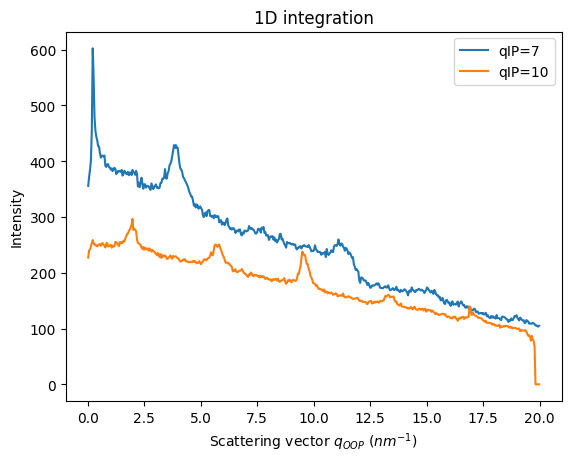

In [58]:
fig, ax = jupyter.subplots()
jupyter.plot1d(res_q7, label="qIP=7", ax=ax)
jupyter.plot1d(res_q10, label="qIP=10", ax=ax)
pass

#### To have a clear idea of what we are integrating here, we can visualize directly the matrix

In [59]:
arr_qip = ai.array_from_unit(shape=data.shape, unit=unit_qip)
arr_qoop = fi.array_from_unit(shape=data.shape, unit=unit_qoop)
arr_qip_7 = np.logical_and(arr_qip > 7.0, arr_qip < 7.2)
arr_qoop_0_20 = np.logical_and(arr_qip > 0.0, arr_qip < 20.0)
data_masked = data * arr_qip_7 * arr_qoop_0_20

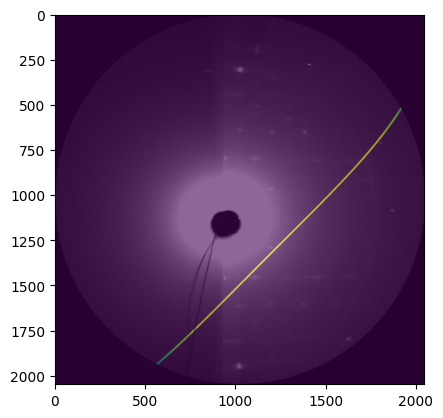

In [60]:
fig, ax = plt.subplots()
ax.imshow(data_masked, vmin=0, vmax=100)
ax.imshow(data, alpha=0.4, vmin=0, vmax=500, cmap="grey")
pass

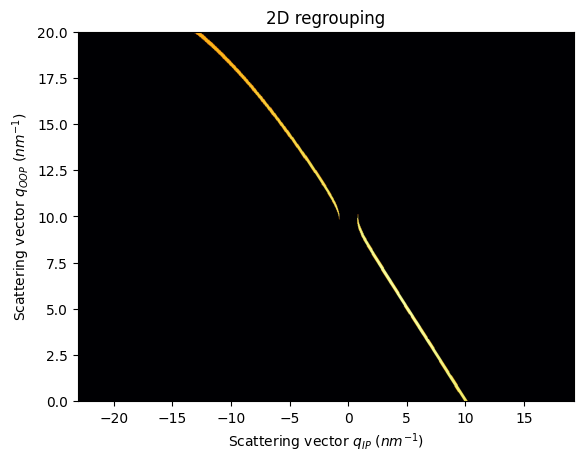

In [61]:
fig, ax = jupyter.subplots()
res2d = fi.integrate2d(data_masked, 1000,1000, unit=(unit_qip, unit_qoop), method=("no", "csr", "cython"))
jupyter.plot2d(res2d, ax=ax)
ax.set_ylim((0,20))
pass

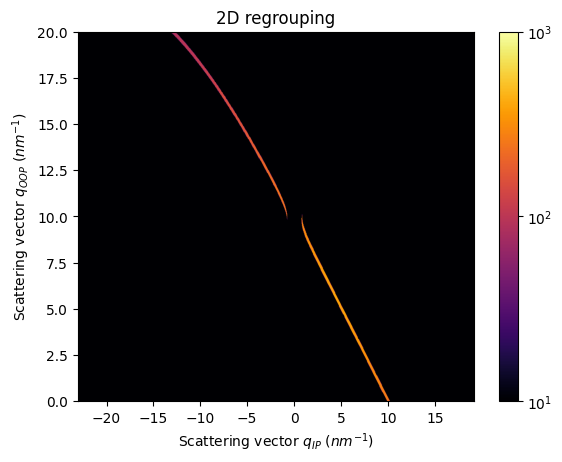

In [62]:
cax = ax.get_children()[0]
cbar = fig.colorbar(cax)
cbar.norm.vmin = 10
cbar.norm.vmax = 1e3
ax.get_figure()

#### We are capturing a rectangular slice from the qip-qoop pattern, or a straight section of the Q-space in the sample frame

##### The integration is generic, we can even extract the slice along the Qoop axis

In [63]:
res_q2p5 = fi.integrate_fiber(data=data, 
                         output_unit=unit_qip, 
                         npt_output=1000,
                         output_unit_range=[-18,18],
                         integrated_unit=unit_qoop, 
                         integrated_unit_range=[2,2.5],
                         npt_integrated=100,
                        )

  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/nobackup/scratch/kieffer/py310/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/nobackup/scratch/kieffer/py310/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/nobackup/scratch/kieffer/py310/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/nobackup/scratch/kieffer/py310/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
    handle._run()
  File "/usr/

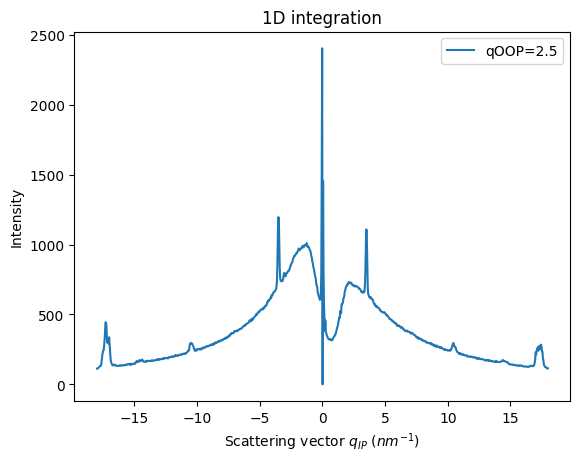

In [64]:
fig, ax = jupyter.subplots()
jupyter.plot1d(res_q2p5, label="qOOP=2.5", ax=ax)
pass

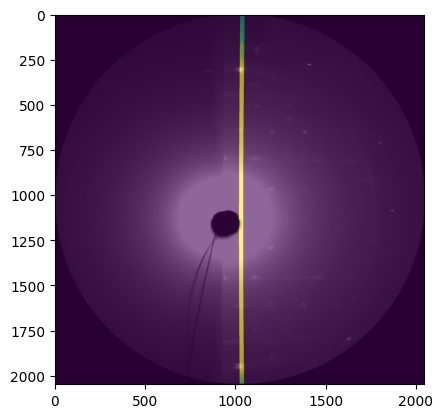

In [65]:
arr_qoop_2p5 = np.logical_and(arr_qoop > 2.0, arr_qoop < 2.5)
arr_qip_m18_18 = np.logical_and(arr_qip > -18.0, arr_qip < 18.0)
data_masked_2 = data * arr_qip_m18_18 * arr_qoop_2p5

fig, ax = plt.subplots()
ax.imshow(data_masked_2, vmin=0, vmax=100)
ax.imshow(data, alpha=0.4, vmin=0, vmax=500, cmap="grey")
pass

##### 

##### Finally, the method pyFAI.AzimuthalIntegrator.integrate_grazing_incidence allows to call the units directly with the incident_angles, tilt_angles and sample_orientation
This way, we don't have to care about instantiating the UnitFiber and then changing the attributes

In [67]:
res_1 = fi.integrate2d_grazing_incidence(data=data,
                                         incident_angle=0.0,
                                         tilt_angle=0.0,
                                         sample_orientation=2,
                                         output_unit="qoop_nm^-1", 
                                         npt_output=500,
                                         output_unit_range=[0,20],
                                         integrated_unit="qip_nm^-1", 
                                         integrated_unit_range=[-2.5,2.5],
                                         npt_integrated=100,
                                         )

res_2 = fi.integrate2d_grazing_incidence(data=data,
                                         incident_angle=np.deg2rad(0.2),
                                         tilt_angle=0.0,
                                         sample_orientation=2,
                                         output_unit="qoop_nm^-1", 
                                         npt_output=500,
                                         output_unit_range=[0,20],
                                         integrated_unit="qip_nm^-1", 
                                         integrated_unit_range=[-2.5,2.5],
                                         npt_integrated=100,
                                         )
 
res_3 = fi.integrate2d_grazing_incidence(data=data,
                                         incident_angle=np.deg2rad(0.2),
                                         tilt_angle=np.deg2rad(45),
                                         sample_orientation=2,
                                         output_unit="qoop_nm^-1", 
                                         npt_output=500,
                                         output_unit_range=[0,20],
                                         integrated_unit="qip_nm^-1", 
                                         integrated_unit_range=[-2.5,2.5],
                                         npt_integrated=100,
                                         )

ValueError: too many values to unpack (expected 1)

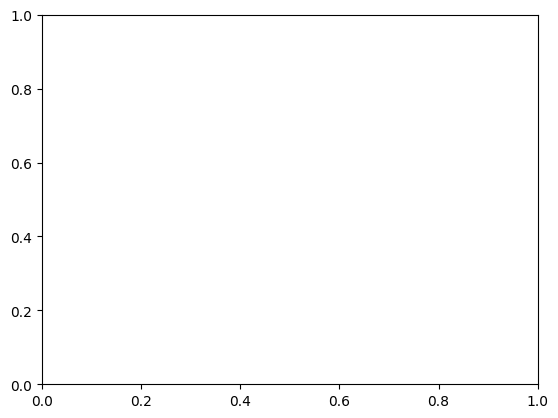

In [68]:
fig, ax = jupyter.subplots()
jupyter.plot1d(res_1, label="incident_angle=0.0", ax=ax)
jupyter.plot1d(res_2, label="incident_angle=0.2º", ax=ax)
jupyter.plot1d(res_3, label="tilt_angle=45º", ax=ax)
pass

In [69]:
res_1

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(1000, 1000), dtype=float32),
 array([-2.30788619e+01, -2.30365106e+01, -2.29941592e+01, -2.29518079e+01,
        -2.29094566e+01, -2.28671052e+01, -2.28247539e+01, -2.27824026e+01,
        -2.27400512e+01, -2.26976999e+01, -2.26553485e+01, -2.26129972e+01,
        -2.25706459e+01, -2.25282945e+01, -2.24859432e+01, -2.24435918e+01,
        -2.24012405e+01, -2.23588892e+01, -2.23165378e+01, -2.22741865e+01,
        -2.22318351e+01, -2.21894838e+01, -2.21471325e+01, -2.21047811e+01,
        -2.20624298e+01, -2.20200784e+01, -2.19777271e+01, -2.19353758e+01,
        -2.18930244e+01, -2.18506731e+01, -2.18083217e+01, -2.17659704e+01,
        -2.17236191e+01, -2.16812677e+01, -2.16389164e+01, -2.15965650e+01,
        -2.15542137e+01, -2.1511

In [38]:
print(f"Total run-time: {time.perf_counter()-t0:.3f}s")

Total run-time: 16.242s


# Conclusions

Now, PyFAI provides the units to represent a data array as a function of in-plane and out-of-plane components of vector q. This is a standard way of represent GIWAXS/GISAXS or fiber diffraction patterns. FiberUnits can be retrieved with a special method and the incident angle, tilt angle and sample orientation parameters can be defined and updated at the moment. Moreover, the methods integrate_fiber and integrate_grazing_incidence allow to get straight slices from the Qip-Qoop patterns.